In [1]:
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from skorch import NeuralNetRegressor
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import torch.nn as nn
import hiplot as hip
import pandas as pd
import numpy as np
import torch

In [2]:
ROOT_PATH = '/home/jovyan/TIL/'
DATA_PATH = f'{ROOT_PATH}/dataset/KBO'

<AxesSubplot: >

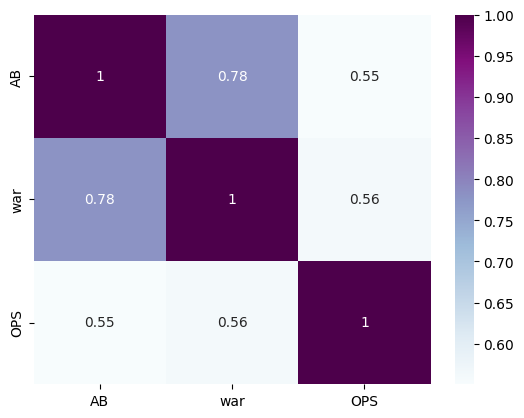

In [3]:
csv    = pd.read_csv(f'{DATA_PATH}/kbo_train.csv')
labels = csv['YOPS']
inputs = csv.drop(['age', 'salary', 'hand2', 'cp', 'YOPS', 'YAB'], axis = 1)
sns.heatmap(inputs.corr(), annot = True, cmap = 'BuPu')

In [4]:
inputs = inputs.to_numpy()
labels = labels.to_numpy().reshape((-1, 1))

In [5]:
scaler = StandardScaler()

scaler.fit(inputs)
inputs = scaler.transform(inputs)

scaler.fit(labels)
labels = scaler.transform(labels)

In [6]:
class ModelBuilder(nn.Module):
    
    def __init__(self):
        
        super(ModelBuilder, self).__init__()
        self.fc1     = nn.Linear( 3,  15, bias = True, dtype = torch.float32)
        self.fc2     = nn.Linear(15,  30, bias = True, dtype = torch.float32)
        self.fc3     = nn.Linear(30,  10, bias = True, dtype = torch.float32)
        self.fc4     = nn.Linear(10,   1, bias = True, dtype = torch.float32)    
        self.dropout = nn.Dropout(0.2)
        
    
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        return F.relu(self.fc4(x))

In [7]:
sk_model  = NeuralNetRegressor(
                ModelBuilder,
                criterion = nn.MSELoss,
            )

param_grid = {
                'optimizer'           : [optim.SGD, optim.RMSprop, optim.Adam],
                'batch_size'          : [32, 64, 128],
                'max_epochs'          : [10, 15, 30],
                'optimizer__lr'       : [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
            }

In [8]:
inputs = inputs.astype(np.float32)
labels = labels.astype(np.float32)

In [9]:
grid        = GridSearchCV(estimator = sk_model, param_grid = param_grid, n_jobs = 3, cv = 2)
grid_result = grid.fit(inputs, labels)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8189        1.1052  1.0129
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1729        0.9584  0.8993
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1781        0.9583  1.0252
      2        1.1729        0.9584  0.0384
      2        0.8174        1.1047  0.0511
      2        1.1756        0.9583  0.0643
      3        1.1729        0.9584  0.0402
      3        0.8165        1.1037  0.0512
      4        1.1729        0.9584  0.0377
      3        1.1788        0.9583  0.0619
      5        1.1729        0.9584  0.0388
      4        0.8109        1.1025  0.0625
      6        1.1729        0.9584  0.0367
      4        1.1736        0.9583  0.0577
      5        0.8130        1.1016  0.0518
      7        1.1729        0.9584  0.0393
      6        0.8119        1.1

In [10]:
params = ['param_' + key for key in grid.param_grid.keys()]
data   = pd.DataFrame(grid.cv_results_)[params + ['mean_test_score']]
data.to_csv(f'{DATA_PATH}/hyper_param.csv')

In [ ]:
exp    = hip.Experiment.from_csv(f'{DATA_PATH}/hyper_param.csv')
exp.display()

In [ ]:
grid.best_params_, grid.best_score_